# Time Series Anomaly Detection
__Thursday 11/5/2020__

### Dataset: Codeup curriculum access logs
Our dataset contains approximately 3 years of unique timestamped access events to Codeup's cirriculum. Let's look at the definitions of each feature in our dataset.

|Feature | Description | datatype |
| :------ | :----------- | :---- |
| `datetime` | Index of the dataset. The date and time a page was viewed by a user | DatetimeIndex |
| `page_viewed` | The content the user accessed | object |
| `user_id` | The user who accessed the curriculum | int64 |
| `cohort_id` | The cohort the user is assigned to | int 64 |
| `ip` | The ip address the user is using to access the curriculum | object |

Let's keep this cornerstone in mind when exploring our data : <strong>_Context_</strong>

> Our goal is to <strong>detect users accessing curriculum pages way beyond the end of their codeup time.</strong><br>

Anomalies include:
> - User behavior : Time of day, number events in a day
> - User with multiple ip addresses
> - Time intervals between events
> - Content viewed
> - Users with access when it should be revoked


### Exercises
Discover users who are accessing our curriculum pages way beyond the end of their codeup time.

### Questions
1. What would the dataframe look like?
> Use time series method for detecting anomalies, like exponential moving average with %b.

2. Bonus: Can you label students who are viewing both the web dev and data science curriculum?
> * Can you label students by the program they are in?
> * Can you label users by student vs. staff?
> * What are Zach, Maggie, Faith, and Ryan's ids?

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta

# import data wrangle functions
import main
import acquire
import prepare
import explore

# Wrangle

In [3]:
# load the dataset
df = acquire.get_cohort_log_data()

In [4]:
df = prepare.prep_curriculum_log_data(df)

In [5]:
print(f'There are {df.shape[0]:,} rows and {df.shape[1]} features in the dataset.')
# display the first 5 rows
df.head()

There are 719,459 rows and 4 features in the dataset.


,page_viewed,user_id,cohort_id,ip
datetime,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   page_viewed  719459 non-null  object
 1   user_id      719459 non-null  int64 
 2   cohort_id    719459 non-null  int64 
 3   ip           719459 non-null  object
dtypes: int64(2), object(2)
memory usage: 27.4+ MB


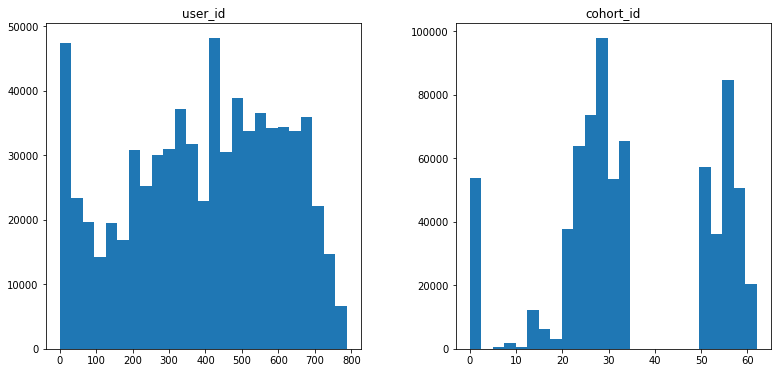

In [7]:
df.hist(figsize=(13, 6),
        grid=False,
        bins=25);

# Exploratory Data Analysis

Discover users who are accessing our curriculum pages way beyond the end of their codeup time.

In [8]:
df.nunique()

page_viewed    2154
user_id         787
cohort_id        41
ip             4339
dtype: int64

## Days with Access
Let's simplify our client's request.

"Users..."
> Staff: Board, Delivery, Placement, Instructors<br>
> Students: Web Dev and Data Science<br>
> Auditors?<br>

"...accessing curriculum"
> Data Science<br>
> Web Development<br>

"...beyond the end of their time at Codeup."
> Darden students will access the curriculum 195 days while enrolled.
> - Calculated via the "Enrollment Agreement"
>
> Students can access Codeup's curriculum up to 6 months after graduating?
> - Approximately 375 days of access if True.<br>



In [9]:
train, validate, test = prepare.split_time_series(df)

# Display the size of each modeling set
print(f'Train size: {len(train) / len(df):.2%}')
print(f'Validate size: {len(validate) / len(df):.2%}')
print(f'Test size: {len(test) / len(df):.2%}')

Train size: 50.00%
Validate size: 30.00%
Test size: 20.00%


In [10]:
df_unique_daily_events = train.resample('D').nunique()

df_unique_daily_events.head()

,page_viewed,user_id,cohort_id,ip
datetime,,,,
2018-01-26,104,50,9,13
2018-01-27,86,18,4,20
2018-01-28,57,19,5,20
2018-01-29,98,61,9,27
2018-01-30,118,61,11,31


In [11]:
df_unique_daily_events.describe()

,page_viewed,user_id,cohort_id,ip
count,613.000000,613.000000,613.000000,613.000000
mean,101.305057,46.163132,8.908646,22.267537
std,40.147765,22.126777,2.533722,8.069968
min,8.000000,4.000000,2.000000,4.000000
25%,72.000000,24.000000,7.000000,17.000000
50%,101.000000,50.000000,9.000000,22.000000
75%,130.000000,63.000000,11.000000,28.000000
max,226.000000,98.000000,16.000000,47.000000


# Unique Pages Viewed

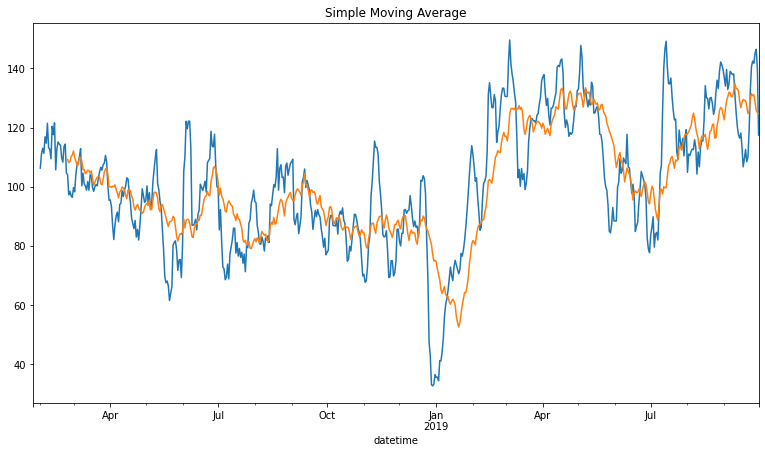

In [12]:
df_unique_daily_events.page_viewed.rolling(7).mean().plot(figsize=(13, 7))
df_unique_daily_events.page_viewed.rolling(30).mean().plot()
plt.title('Simple Moving Average');

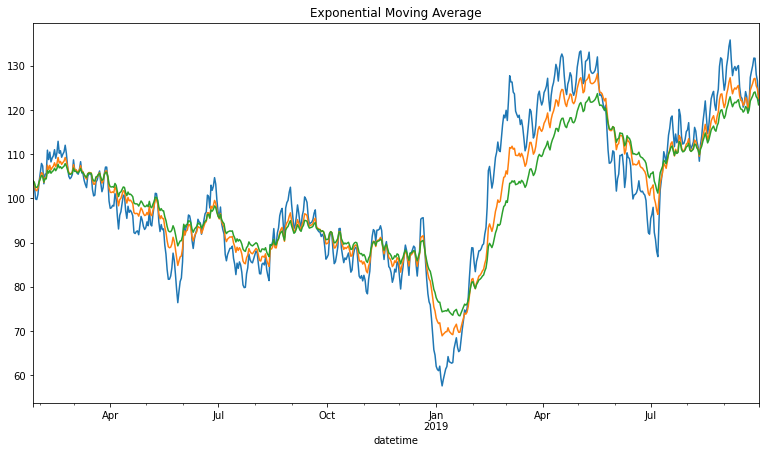

In [13]:
df_unique_daily_events.page_viewed.ewm(span=30, adjust=False).mean().plot(figsize=(13, 7));
df_unique_daily_events.page_viewed.ewm(span=60, adjust=False).mean().plot(figsize=(13, 7));
df_unique_daily_events.page_viewed.ewm(span=90, adjust=False).mean().plot(figsize=(13, 7))
plt.title('Exponential Moving Average');

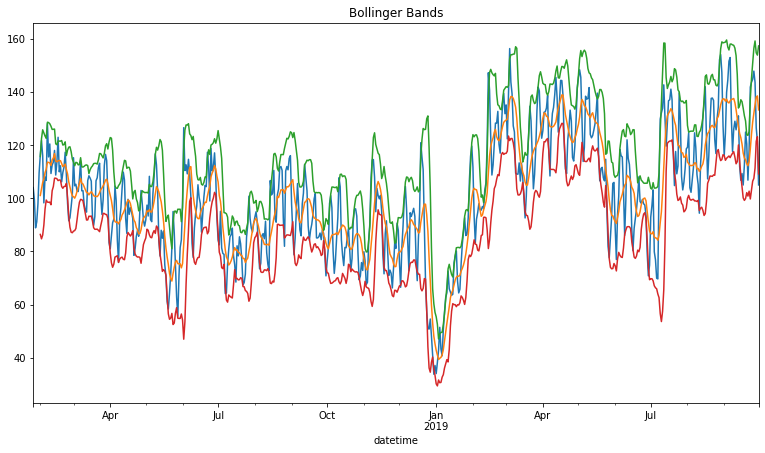

In [14]:
ema_long = df_unique_daily_events.page_viewed.ewm(span=7, adjust=False).mean()
midband = ema_long.rolling(7).mean()
ub = midband + ema_long.rolling(7).std()*1.5
lb = midband - ema_long.rolling(7).std()*1.5

ema_long.plot(figsize=(13, 7))
midband.plot()
ub.plot()
lb.plot()
plt.title('Bollinger Bands');

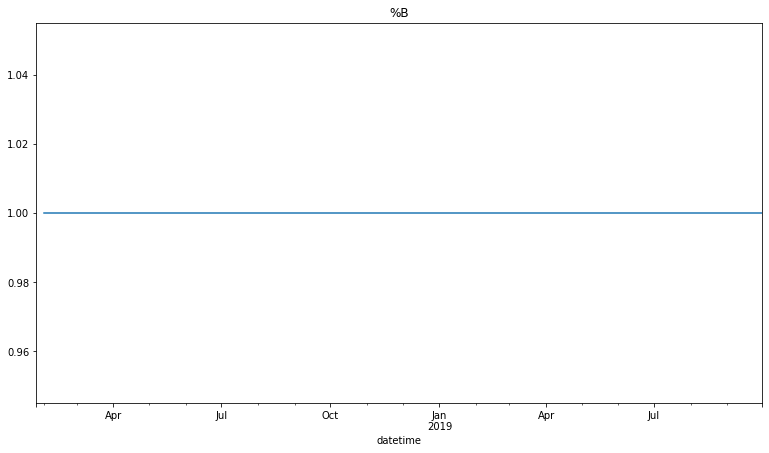

In [15]:
pct_b = pd.DataFrame({'pct_b': (df_unique_daily_events.page_viewed-lb)/(df_unique_daily_events.page_viewed-lb)})
test = pd.concat([df_unique_daily_events, pct_b], axis=1)

test.pct_b.plot(figsize=(13, 7))
plt.title('%B');

# Unique User ID's

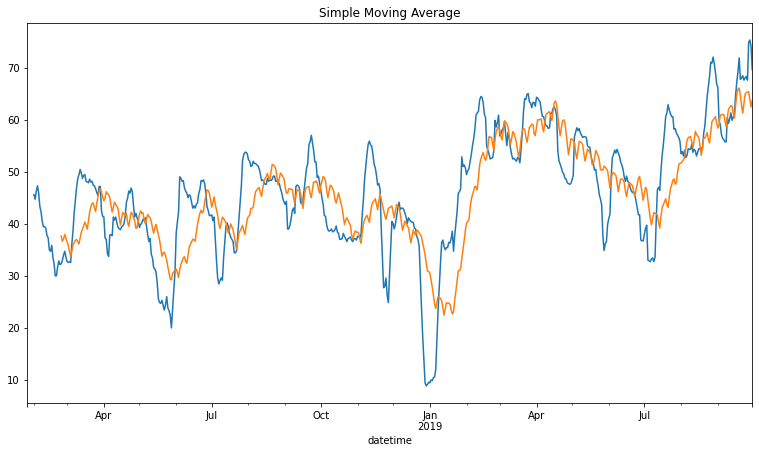

In [16]:
df_unique_daily_events.user_id.rolling(7).mean().plot(figsize=(13, 7))
df_unique_daily_events.user_id.rolling(30).mean().plot()
plt.title('Simple Moving Average');

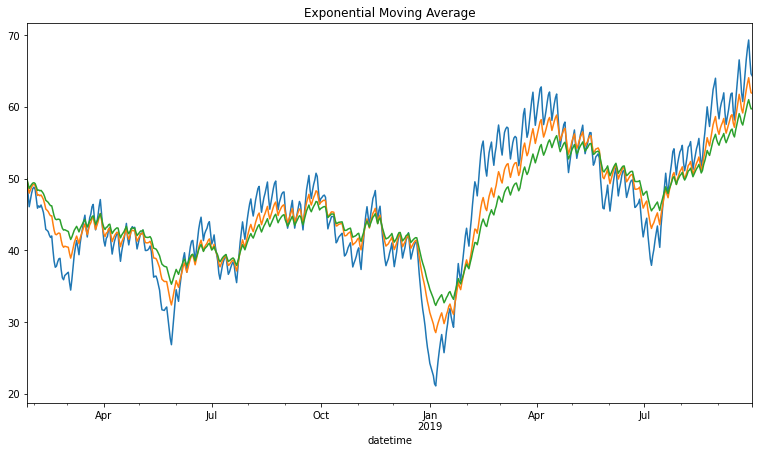

In [17]:
df_unique_daily_events.user_id.ewm(span=30, adjust=False).mean().plot(figsize=(13, 7));
df_unique_daily_events.user_id.ewm(span=60, adjust=False).mean().plot(figsize=(13, 7));
df_unique_daily_events.user_id.ewm(span=90, adjust=False).mean().plot(figsize=(13, 7))
plt.title('Exponential Moving Average');

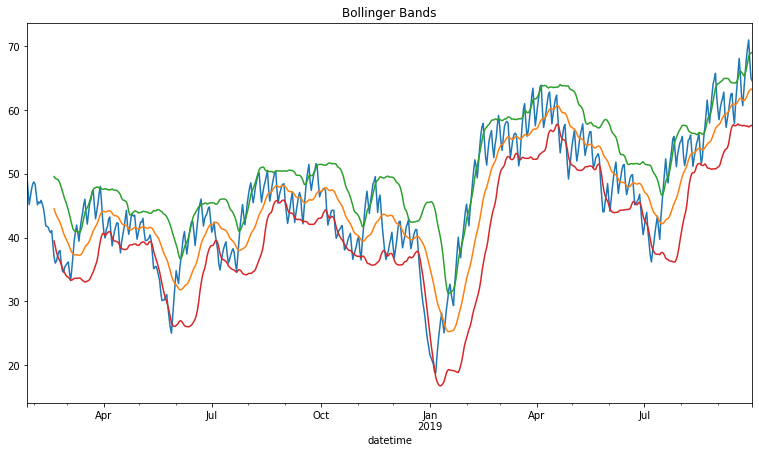

In [18]:
ema_long = df_unique_daily_events.user_id.ewm(span=24, adjust=False).mean()
midband = ema_long.rolling(24).mean()
ub = midband + ema_long.rolling(24).std()*1.5
lb = midband - ema_long.rolling(24).std()*1.5

ema_long.plot(figsize=(13, 7))
midband.plot()
ub.plot()
lb.plot()
plt.title('Bollinger Bands');

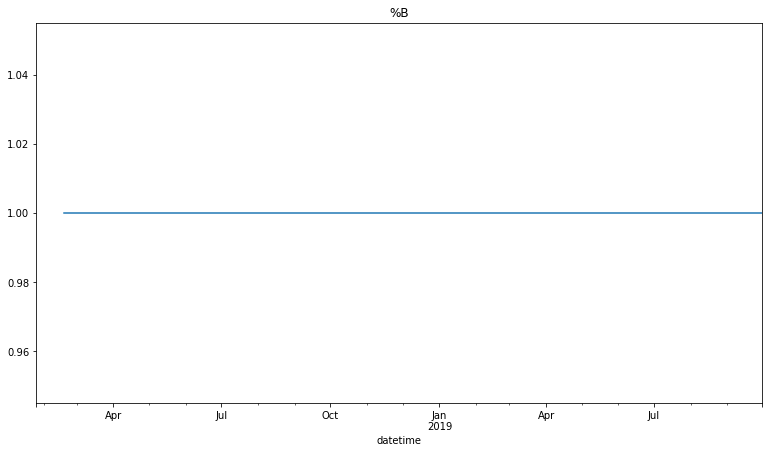

In [19]:
pct_b = pd.DataFrame({'pct_b': (df_unique_daily_events.user_id-lb)\
                                /(df_unique_daily_events.user_id-lb)})
test = pd.concat([df_unique_daily_events, pct_b], axis=1)

test.pct_b.plot(figsize=(13, 7))
plt.title('%B');

# Unique IP Addresses

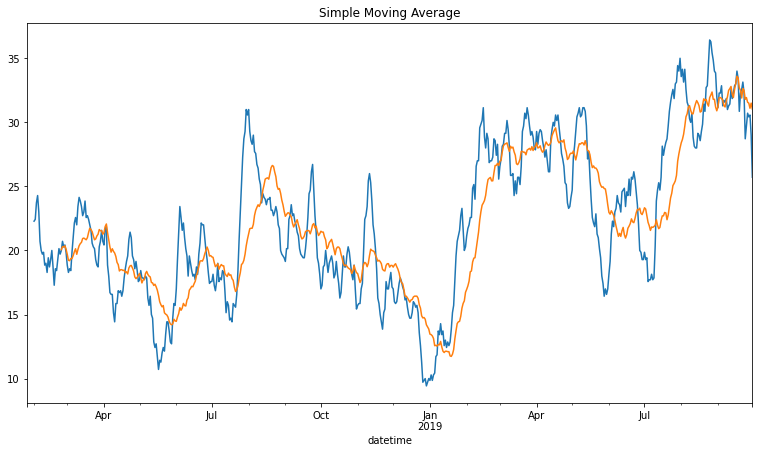

In [20]:
df_unique_daily_events.ip.rolling(7).mean().plot(figsize=(13, 7))
df_unique_daily_events.ip.rolling(30).mean().plot()
plt.title('Simple Moving Average');

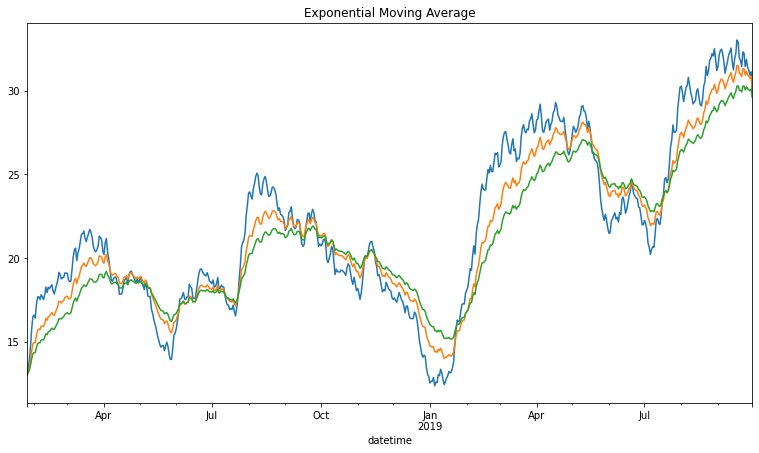

In [21]:
df_unique_daily_events.ip.ewm(span=30, adjust=False).mean().plot(figsize=(13, 7));
df_unique_daily_events.ip.ewm(span=60, adjust=False).mean().plot(figsize=(13, 7));
df_unique_daily_events.ip.ewm(span=90, adjust=False).mean().plot(figsize=(13, 7))
plt.title('Exponential Moving Average');

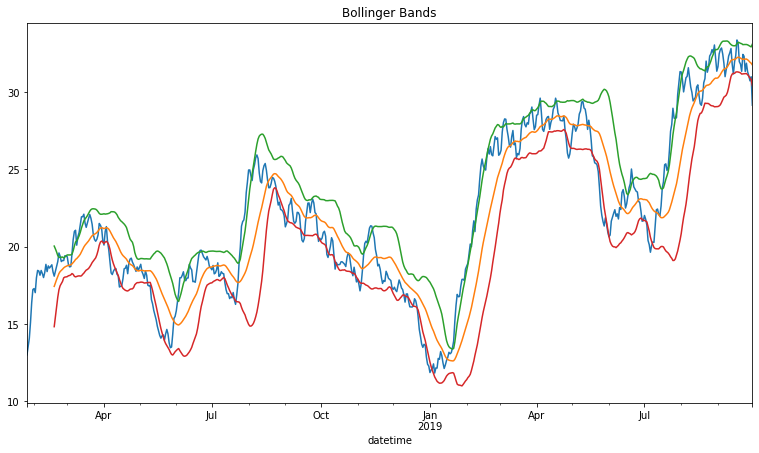

In [22]:
ema_long = df_unique_daily_events.ip.ewm(span=24, adjust=False).mean()
midband = ema_long.rolling(24).mean()
ub = midband + ema_long.rolling(24).std()*1.5
lb = midband - ema_long.rolling(24).std()*1.5

ema_long.plot(figsize=(13, 7))
midband.plot()
ub.plot()
lb.plot()
plt.title('Bollinger Bands');

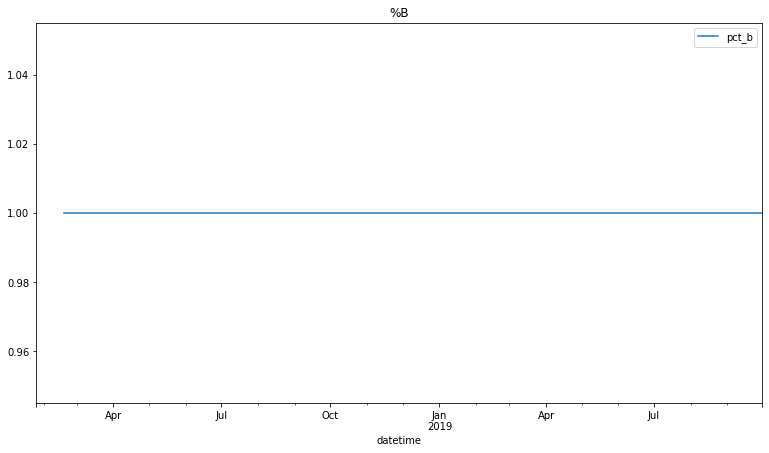

In [23]:
pct_b = pd.DataFrame({'pct_b': (df_unique_daily_events.ip-lb)\
                                /(df_unique_daily_events.ip-lb)})
pct_b.plot(figsize=(13, 7))
plt.title('%B');

<br>
<br>
<br>
<br>
<br>
<br>

# Appendix

## Intervals between events

In [24]:
# reset datetime index
df = df.reset_index()
train, validate, test = prepare.split_time_series(df)

In [25]:
df_user_times = train[['user_id', 'datetime']]\
                .sort_values(by='user_id')\
                .reset_index(drop=True)\
                .set_index('user_id')

In [26]:
df_user_times.shape

(359729, 1)

In [27]:
# Calculate the number of days between log events
df_user_times['interval_between_events'] = df_user_times.groupby('user_id')['datetime'].transform(pd.Series.diff)
df_user_times = df_user_times.reset_index()

df_user_times['days_between_events'] = ((df_user_times.interval_between_events.dt.total_seconds().fillna(0)) \
                                         / 86400) \
                                         .astype(np.int)

df_user_times['hours_between_events'] = ((df_user_times.interval_between_events.dt.total_seconds().fillna(0)) \
                                          / 3600) \
                                          .astype(np.int)

df_user_times['seconds_between_events'] = (df_user_times.interval_between_events.dt.total_seconds().fillna(0)) \
                                          .astype(np.int)

In [28]:
df_user_times.describe()

,user_id,interval_between_events,days_between_events,hours_between_events,seconds_between_events
count,359729.000000,359217,359729.000000,359729.000000,3.597290e+05
mean,251.416311,-1 days +23:59:31.308317814,0.000350,-0.007853,-2.865085e+01
std,139.702569,84 days 20:24:15.109078351,84.547439,2034.711892,7.325836e+06
min,1.000000,-605 days +01:45:17,-604.000000,-14518.000000,-5.226568e+07
25%,136.000000,-16 days +17:14:46,-15.000000,-365.000000,-1.314259e+06
50%,269.000000,0 days 00:00:00,0.000000,0.000000,0.000000e+00
75%,363.000000,15 days 07:03:09,15.000000,365.000000,1.314388e+06
max,512.000000,602 days 02:36:42,602.000000,14450.000000,5.202220e+07


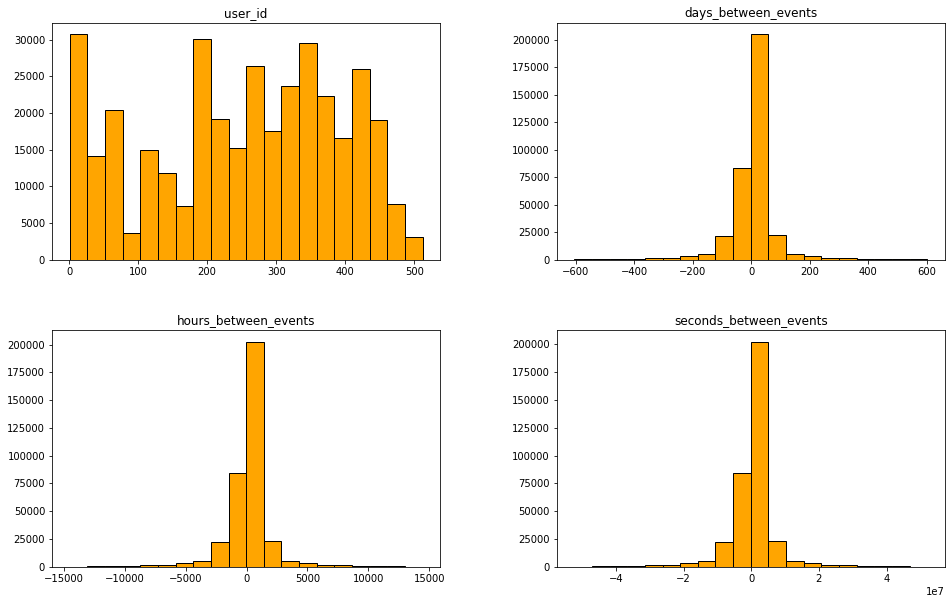

In [29]:
df_user_times.hist(figsize=(16, 10),
                   grid=False,
                   bins=20,
                   color='orange',
                   ec='black');

In [30]:
# Number of days Darden data scientists will have
# accessed the curriculum while at Codeup.
datetime(2021, 1, 21) - datetime(2020, 7, 10) + (timedelta(30) * 6)

datetime.timedelta(days=375)

In [31]:
# Groupby user id and aggregate by date to find the first access and the last access
df_user_age = df.groupby('user_id').datetime.agg(['min', 'max'])

# Calculate the number of days a user has had access to the curriculum.
# Convert the timedelta to days. Convert days from float to an integer value.
df_user_age = df_user_age.assign(
    days_with_access = (df_user_age['max'] \
                       - df_user_age['min'])
                      .astype('timedelta64[D]')
                      .astype(np.int64)
)

# rename columns for clarity
df_user_age.rename(columns={'min':'first_access',
                            'max':'last_access'},
                   inplace=True)

In [32]:
# Beautiful
df_user_age.head()

,first_access,last_access,days_with_access
user_id,,,
1,2018-01-26 09:55:03,2020-11-02 11:13:40,1011
2,2018-01-26 09:56:24,2018-05-10 18:25:38,104
3,2018-01-26 09:56:46,2019-04-06 21:32:32,435
4,2018-01-26 09:58:26,2018-03-27 14:28:18,60
5,2018-01-26 09:59:22,2018-07-19 14:08:20,174


In [33]:
# Days with access statistics
df_user_age.describe()

,days_with_access
count,787.000000
mean,258.255400
std,244.278102
min,0.000000
25%,67.000000
50%,177.000000
75%,384.500000
max,1011.000000


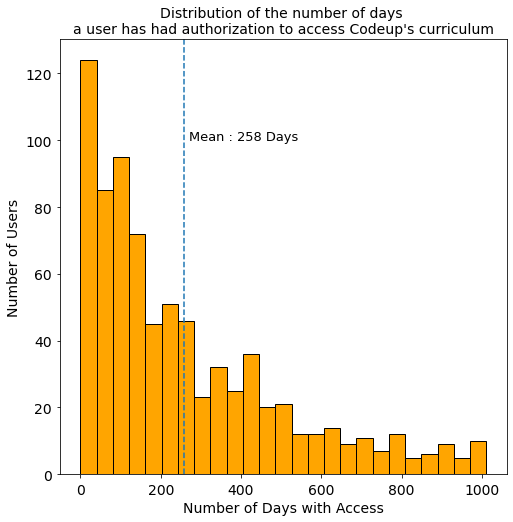

In [34]:
# Plot a histogram to show the distribution of days with access
df_user_age.days_with_access.hist(figsize=(8, 8),
                                  color='orange',
                                  ec='black',
                                  bins=25,
                                  grid=False)

# Format the chart
plt.title('Distribution of the number of days \na user has had authorization to access Codeup\'s curriculum',
           fontsize=14)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('Number of Days with Access', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.axvline(df_user_age.days_with_access.mean(), linestyle='--')
plt.text(270, 100, 'Mean : 258 Days', fontsize=13);

# Detect Outliers
1. User the IQR range rule to find anonamlous users.
2. View anonamlous users activity.

In [35]:
# set a threshold for access using IQR
Q3 = df_user_age.days_with_access.quantile(.75)
Q1 =  df_user_age.days_with_access.quantile(.25)

IQR_MULTIPLIER = 1.5
IQR = Q3 - Q1

upper_bound = Q3 + (IQR*IQR_MULTIPLIER)
lower_bound = Q1 - (IQR*IQR_MULTIPLIER)

In [36]:
Q1

67.0

In [37]:
df_anomalies = df_user_age[(df_user_age.days_with_access > upper_bound) \
                           | (df_user_age.days_with_access < lower_bound)]
df_anomalies = df_anomalies.sort_values(by=['last_access', 'days_with_access'], ascending=False)

In [38]:
one_month = timedelta(30)
past_thirty_days = (datetime.now() - one_month)
df_anomalies[df_anomalies.last_access >= past_thirty_days]

,first_access,last_access,days_with_access
user_id,,,
211,2018-06-11 09:27:32,2020-11-02 16:43:37,875
11,2018-01-26 10:14:47,2020-11-02 16:42:06,1011
53,2018-01-28 18:48:19,2020-11-02 16:09:45,1008
20,2018-01-26 10:44:06,2020-11-02 12:15:37,1011
1,2018-01-26 09:55:03,2020-11-02 11:13:40,1011
88,2018-02-05 21:40:45,2020-10-30 11:40:44,997
64,2018-01-29 13:50:57,2020-10-29 17:00:03,1004
145,2018-03-19 08:21:09,2020-10-26 20:20:46,952
41,2018-01-26 13:58:07,2020-10-26 09:39:38,1003


In [39]:
train, validate, test = prepare.split_time_series(df)

# Display the size of each modeling set
print(f'Train size: {len(train) / len(df):.2%}')
print(f'Validate size: {len(validate) / len(df):.2%}')
print(f'Test size: {len(test) / len(df):.2%}')

Train size: 50.00%
Validate size: 30.00%
Test size: 20.00%


## User Activity

In [40]:
train.nunique()

datetime       347098
page_viewed      1590
user_id           512
cohort_id          31
ip               2402
dtype: int64

In [41]:
user_activity = explore.user_stats(train)

In [42]:
user_activity.describe()

,user_id,number_of_unique_ips,number_of_access_events,unique_pages_viewed
count,533.000000,533.000000,533.000000,533.000000
mean,253.163227,6.849906,674.913696,102.242026
std,148.414951,9.500692,748.543146,71.934308
min,1.000000,1.000000,1.000000,1.000000
25%,123.000000,2.000000,104.000000,33.000000
50%,253.000000,5.000000,489.000000,104.000000
75%,380.000000,8.000000,1026.000000,153.000000
max,512.000000,148.000000,7532.000000,502.000000


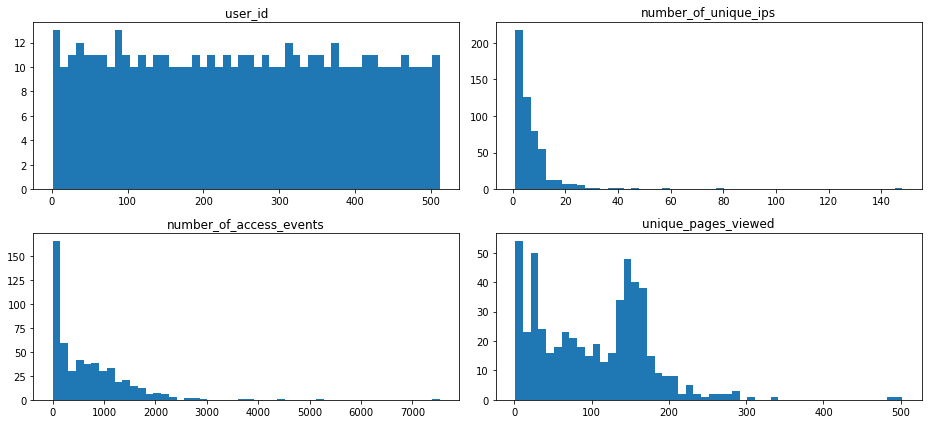

In [43]:
user_activity.hist(figsize=(13, 6),
                   grid=False,
                   bins=50);
plt.tight_layout()

In [44]:
user_activity.nlargest(20, columns='number_of_unique_ips')

,user_id,number_of_unique_ips,number_of_access_events,unique_pages_viewed
cohort_id,,,,
25,228,148,1392,145
25,226,79,1284,158
29,337,57,2183,173
33,460,48,1069,96
23,127,46,2563,287
27,304,42,2061,174
23,128,39,1395,170
17,314,31,2056,140
0,111,29,753,113


In [45]:
user_activity.nlargest(20, columns='number_of_access_events')

,user_id,number_of_unique_ips,number_of_access_events,unique_pages_viewed
cohort_id,,,,
14,53,9,7532,275
29,344,9,5134,210
28,11,11,4479,487
1,64,8,3767,266
28,64,11,3655,225
32,423,26,2894,183
0,354,9,2810,261
1,11,6,2735,209
32,418,2,2598,153


In [46]:
user_activity.nlargest(20, columns=['unique_pages_viewed'])

,user_id,number_of_unique_ips,number_of_access_events,unique_pages_viewed
cohort_id,,,,
28,1,17,2160,502
28,11,11,4479,487
28,248,6,1499,332
28,404,6,1263,302
0,368,9,2043,289
23,127,46,2563,287
0,349,7,1565,283
0,363,7,2212,276
14,53,9,7532,275


## Hourly Logs

In [47]:
train_agg = train.groupby(['datetime', 'cohort_id'])['user_id'] \
                    .nunique() \
                    .reset_index() \
                    .rename(index=str, 
                            columns={'user_id': 'users_viewed'}) \
                    .set_index('datetime')

In [48]:
train_agg.head()

,cohort_id,users_viewed
datetime,,
2018-01-26 09:55:03,8,1
2018-01-26 09:56:02,8,1
2018-01-26 09:56:05,8,1
2018-01-26 09:56:06,8,1
2018-01-26 09:56:24,22,1


In [49]:
# create hourly aggregated datasets
train_hourly_1hr = train_agg.resample('H').users_viewed.agg(['sum'])
train_hourly_1hr.rename(columns={'sum': 'times_viewed'}, inplace=True)

train_hourly_1hr['hour'] = train_hourly_1hr.index.hour
train_hourly_1hr['access_type'] = pd.cut(train_hourly_1hr['hour'],
                                         bins=[0, 9, 17, 24],
                                         labels=['Before Class', 'During Class', 'After Class'])

# create daily aggregated datasets
train_daily_1d = train_agg.resample('D').users_viewed.agg(['sum'])
train_daily_1d.rename(columns={'sum': 'times_viewed'}, inplace=True)
train_daily_1d['day_of_week'] = train_daily_1d.index.day_name()

# create  weekely aggregated datasets
train_weekly_1w = train_agg.resample('W').users_viewed.agg(['sum'])
train_weekly_1w.rename(columns={'sum': 'times_viewed'}, inplace=True)
train_weekly_1w['week_num'] = train_weekly_1w.index.isocalendar().week

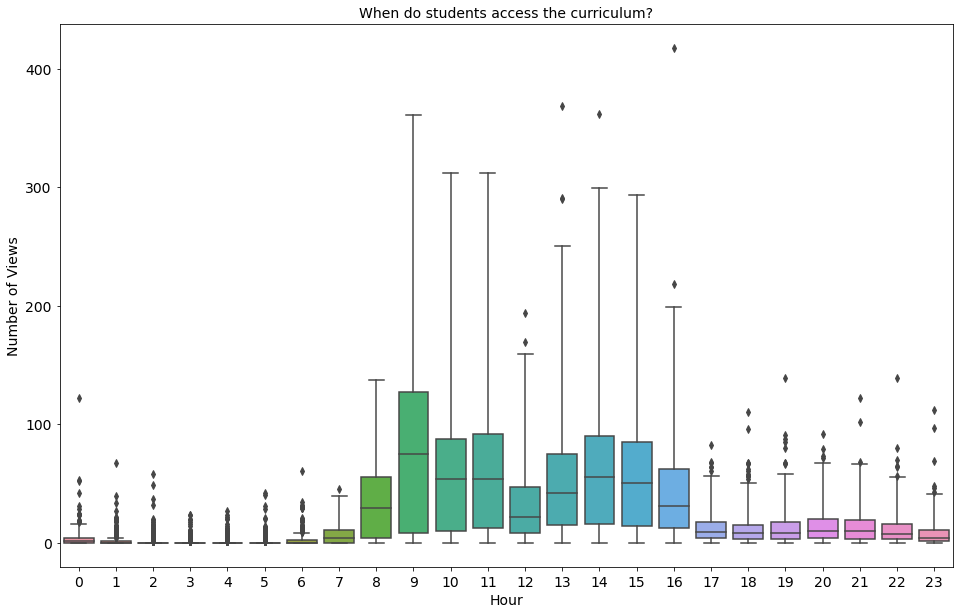

In [50]:
plt.figure(figsize=(16,10))
sns.boxplot(x=train_hourly_1hr['hour'],
            y=train_hourly_1hr.times_viewed,
            whis=3)
plt.title('When do students access the curriculum?', fontsize=14)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Number of Views', fontsize=14);

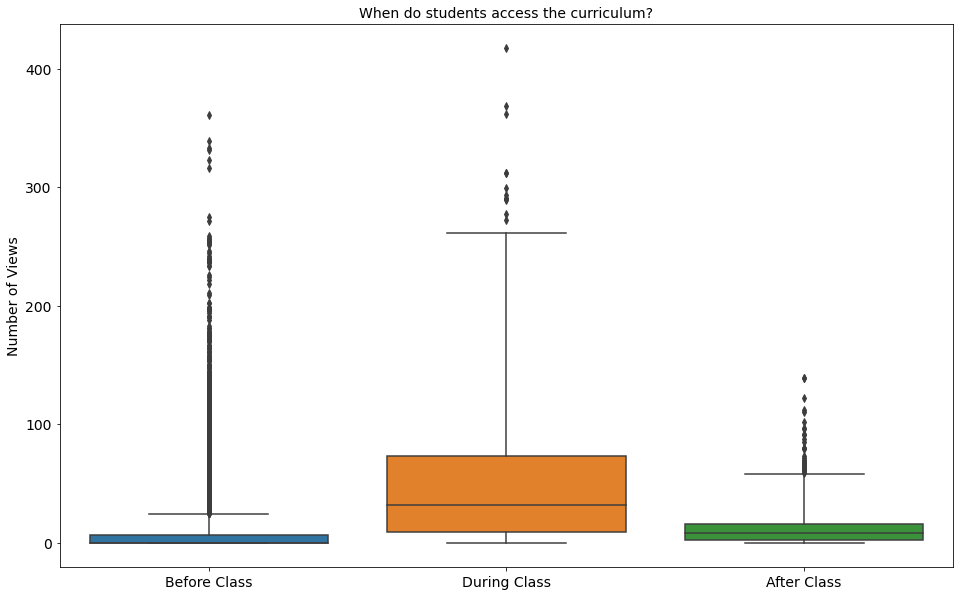

In [51]:
plt.figure(figsize=(16,10))
sns.boxplot(x=train_hourly_1hr.access_type,
            y=train_hourly_1hr.times_viewed,
            whis=3)
plt.title('When do students access the curriculum?', fontsize=14)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('')
plt.ylabel('Number of Views', fontsize=14);

In [52]:
train_hourly_1hr.head()

,times_viewed,hour,access_type
datetime,,,
2018-01-26 09:00:00,11,9,Before Class
2018-01-26 10:00:00,62,10,During Class
2018-01-26 11:00:00,101,11,During Class
2018-01-26 12:00:00,27,12,During Class
2018-01-26 13:00:00,52,13,During Class


## Daily Logs

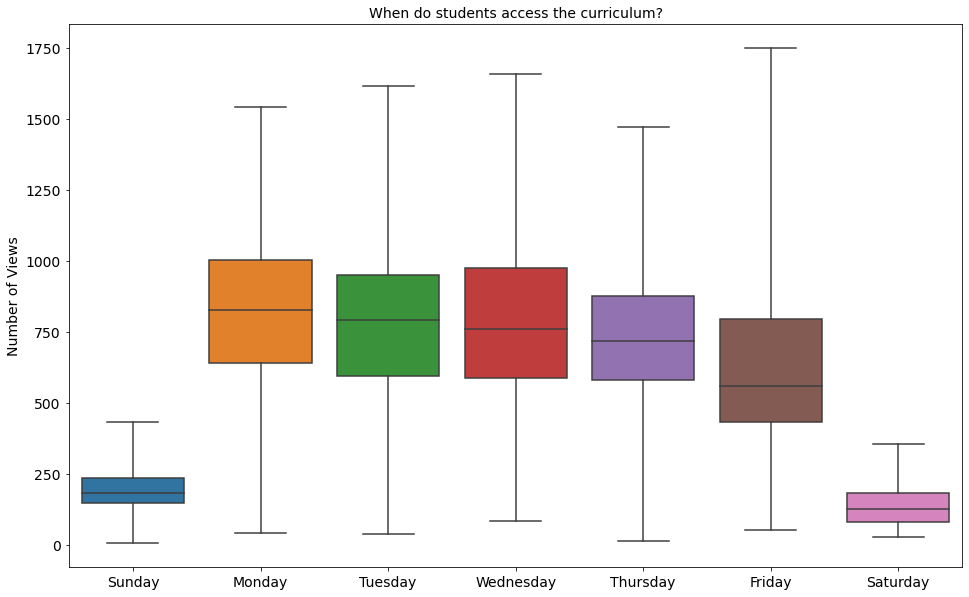

In [53]:
plt.figure(figsize=(16,10))
sns.boxplot(x=train_daily_1d.day_of_week,
            y=train_daily_1d['times_viewed'],
            order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
            whis=3)
plt.title('When do students access the curriculum?', fontsize=14)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('')
plt.ylabel('Number of Views', fontsize=14);